# AI model for training (shark fin) artifacts on GOES-R

[How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)

[TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

[ROC curves for a simple CNN multi-class model](https://discuss.pytorch.org/t/roc-curves-for-a-simple-cnn-multi-class-model/98069)

In [38]:
%load_ext tensorboard
#%reload_ext tensorboard
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os.path as op
import os
from subprocess import Popen
import tensorboard
import datetime
import sys
import time

# imports
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image, make_grid
from torch.utils.data import TensorDataset


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
nr.seed = 42
data_train_dir = '/scratch/adomakor412/BW_train/'
data_test_dir = '/scratch/adomakor412/BW_test/'
data_val_dir = '/scratch/adomakor412/BW_val/'

# Tensorboard command line set up

#### [How to “reset” tensorboard data after killing tensorflow instance](https://stackoverflow.com/questions/34454721/how-to-reset-tensorboard-data-after-killing-tensorflow-instance)

#### [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started)


In [3]:
stamp = datetime.datetime.now().strftime('%b-%d-%y:%H%M_%s')

In [4]:
batch_size = 64

In [16]:
myTestData = []
myTrainData = []
myValData = []

def load_split_train_test(traindir, testdir, valdir):
    train_transforms = transforms.Compose([transforms.Resize(32),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor(),
                                      ])
    val_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(traindir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(testdir,
                    transform=test_transforms)
    val_data = datasets.ImageFolder(valdir,
                    transform=test_transforms)
    
    
#     train_idx = list(range(len(traindir)))
#     nr.shuffle(np.array(train_idx))
    
#     test_idx = list(range(len(testdir)))
#     nr.shuffle(np.array(test_idx))
    
#     val_idx = list(range(len(valdir)))
#     nr.shuffle(np.array(val_idx))

    train_idx = list(range(len(traindir)))
    nr.shuffle(train_idx)
    
    test_idx = list(range(len(testdir)))
    nr.shuffle(test_idx)
    
    val_idx = list(range(len(valdir)))
    nr.shuffle(val_idx)
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    val_sampler = SubsetRandomSampler(val_idx)

#     trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
#     testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)
#     valloader = torch.utils.data.DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
    testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    valloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
    
    myTestData.append(test_data)
    myTrainData.append(train_data)
    myValData.append(val_data)
    
    return trainloader, testloader, valloader



In [17]:
trainloader, testloader, valloader = load_split_train_test(data_train_dir,
                                                           data_test_dir, 
                                                           data_val_dir)

print(valloader.dataset.classes)
print(testloader.dataset.classes)
print(trainloader.dataset.classes)

['fillin', 'sharkfin']
['fillin', 'sharkfin']
['fillin', 'sharkfin']


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
# model = models.resnet50(pretrained=True)
PATH = 'MODELS/model_epoch_99_May-10-21:1605_1620677105.pth'
model = torch.load(PATH)
#torch.save(model, 'ResnetPretrained.pth');

In [19]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

In [20]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # m input image channel, n output channels, rxr square convolution
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 2)

# #         super(Net, self).__init__()
# #         self.conv1 = nn.Conv2d(3, 32, 5)
# #         self.pool = nn.MaxPool2d(2, 2)
# #         self.conv2 = nn.Conv2d(32, 64, 5)
# #         self.fc1 = nn.Linear(64*9*9, 1024)
# #         self.fc2 = nn.Linear(1024, 7)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# #         x = self.pool(F.relu(self.conv1(x)))
# #         x = self.pool(F.relu(self.conv2(x)))
# #         x = x.view(x.size(0), -1)

# #         #x = x.view(-1, 64)
# #         x = F.relu(self.fc1(x))
# #         x = F.relu(self.fc2(x))
# #         x = self.fc2(x)
# #         return x


# net = Net()

In [21]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    fig.savefig(f'epoch_{epoch}-{stamp}.png')
    return fig

In [23]:
trainloader.dataset

Dataset ImageFolder
    Number of datapoints: 1455
    Root location: /scratch/adomakor412/BW_train/
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [24]:
#sufficiently large pixel square side size for given number of random  set of images
#from torchvision import transforms
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

def get_random_images(num):
    data = datasets.ImageFolder(data_train_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    #print(image_tensor)
    input = image_tensor
    input = input.to(device)#defined
    output = model(input)#defined
    index = output.data.cpu().numpy().argmax()
    return index

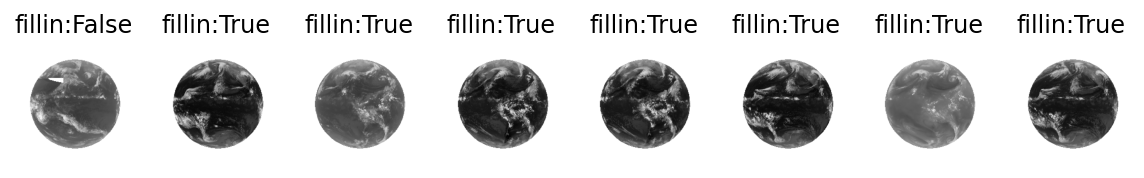

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

classes = trainloader.dataset.classes

to_pil = transforms.ToPILImage()
images, labels = get_random_images(8)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [33]:
#%config Completer.use_jedi = False
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [39]:

# train_X = np.float32(trainloader.dataset)
train_X = trainloader.dataset.imgs
test_X = testloader.dataset.targets
train_y = trainloader.dataset.imgs
test_y = testloader.dataset.targets

train_dataset = TensorDataset(torch.Tensor(train_X), torch.Tensor(train_y))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

net = Net()

criterion = nn.CrossEntropyLoss()# cross entropy loss

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

net.train()

# for epoch in range(1000):
    
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         out = net(inputs)
#         loss = criterion(out, targets.long())
#         loss.backward()
#         optimizer.step()

#     if epoch % 100 == 0:
#         print('number of epoch', epoch, 'loss', loss.item())

predict_out = net(torch.Tensor(test_X))
_, predict_y = torch.max(predict_out, 1)

print('prediction accuracy', accuracy_score(test_y.data, predict_y.data))

print('macro precision', precision_score(test_y.data, predict_y.data, average='macro'))
print('micro precision', precision_score(test_y.data, predict_y.data, average='micro'))
print('macro recall', recall_score(test_y.data, predict_y.data, average='macro'))
print('micro recall', recall_score(test_y.data, predict_y.data, average='micro'))

ValueError: too many dimensions 'str'